In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, log
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

In [2]:
def W_calc(Sw, m1, m2):        
    W = np.dot(np.linalg.inv(Sw), (m1-m2).T) 
    W=W/np.linalg.norm(W)                  
    return W                                  

In [3]:
def getcov_mx(X, Y=None):
    if Y is None:
        m = np.mean(X, axis=0)
        interim = np.dot((X-m).T, (X-m))
        return (interim / X.shape[0])                  
    else:                                  
        Sw = getcov_mx(X) + \
              getcov_mx(Y)                
        return Sw 
      

In [4]:
def getgaus_disp(X):           
    m = np.mean(X)
    v = np.var(X)                                  
    Z = -((X-m)**2)/(2*v)
    Y = (1/sqrt(2*np.pi*v)) * np.exp(Z)
    return Y

In [5]:
def resolve_quad(a, b, c):
    delta = ((b**2) - 4*a*c)
    root1 = (-b + sqrt(delta))/(2*a)
    root2 = (-b - sqrt(delta))/(2*a)
    return (root1, root2)

In [6]:
def threshold(X1, X2):   
    m1 = np.mean(X1)
    v1 = np.var(X1)
    m2 = np.mean(X2)
    v2 = np.var(X2)
                           
    a = (1/v2 - 1/v1)
    b = 2*(m1/v1 - m2/v2)
    c = (((m2**2)/v2 - (m1**2)/v1) + log(v2/v1))
    return resolve_quad(a, b, c)

In [7]:
datafile=pd.read_csv('dataset_FLD.csv',header=None)
datafile.columns=['x1','x2','x3','y']

In [8]:
#1)training
datafile_pos, datafile_neg = [x for _, x in datafile.groupby(datafile['y'] == 0)]
class_plus = np.array(datafile_pos.drop('y', 1))
class_minus = np.array(datafile_neg.drop('y', 1))              

In [9]:
W = W_calc(Sw=getcov_mx(class_plus, class_minus),                
                m1=np.mean(class_plus, axis=0),                     
                m2=np.mean(class_minus, axis=0)) 

print(W)

[-0.00655686 -0.01823739  0.99981218]


In [10]:
pc_lowered = np.sort(np.dot(class_plus, W.T))      
nc_lowered = np.sort(np.dot(class_minus, W.T))

In [11]:
thresh, Q  = threshold(pc_lowered, nc_lowered)
print(thresh)

-0.3893028020993765


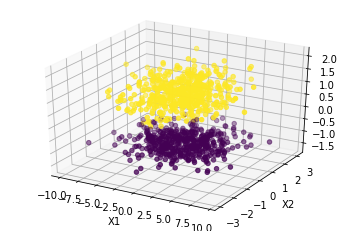

In [12]:
#2)plotting
xa=plt.axes(projection='3d')
plt.xlabel('X1')
plt.ylabel('X2')


info_axisz = datafile['x3']
info_axisy = datafile['x2']
info_axisx = datafile['x1']

xa.scatter3D(info_axisx,info_axisy,info_axisz,c=datafile['y'])
plt.show()

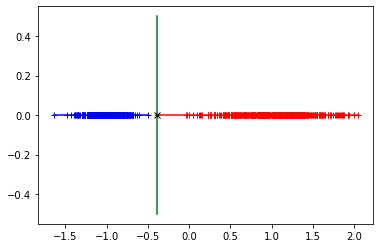

In [13]:
x, y = np.array([thresh]*6), np.linspace(-0.5, 0.5, 6) 

fig, xa = plt.subplots()
xa.plot(pc_lowered, np.zeros(len(pc_lowered)), color="red", marker="+")
xa.plot(nc_lowered, np.zeros(len(nc_lowered)), color="blue", marker="+")
xa.plot(x, y, color="green")
xa.plot(thresh,0,color="black",marker="x")
plt.show()

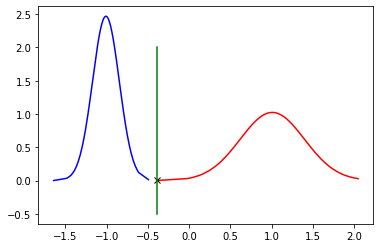

In [14]:
x, y = np.array([thresh]*6), np.linspace(-0.5,2, 6)

m1=np.mean(pc_lowered)
var_1=np.var(pc_lowered)

fig, xa = plt.subplots()
Yp = getgaus_disp(pc_lowered)  
Yn = getgaus_disp(nc_lowered)
xa.plot(pc_lowered, Yp, color="red")
xa.plot(nc_lowered, Yn, color="blue")
xa.plot(thresh,(1/np.sqrt(2*np.pi*var_1))*np.exp(-1*np.square(np.subtract(thresh, m1))/(2*var_1)),color="black",marker="x")  
xa.plot(x, y, color="green")
plt.show()

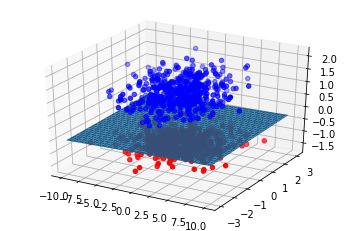

In [15]:
fig=plt.figure() 
xa = plt.axes(projection ='3d')
           
xa.scatter(class_plus[:,0],class_plus[:,1],class_plus[:,2],color = 'b')
xa.scatter(class_minus[:,0],class_minus[:,1],class_minus[:,2],color = 'r')

x = np.linspace(-10,10,100)
y = np.linspace(-3,3,30)

X,Y = np.meshgrid(x,y)
Z=(thresh-W[0]*X - W[1]*Y)/(W[2])    

xa = fig.gca(projection='3d')
xa.plot_surface(X, Y, Z)
plt.show()

In [16]:
print(W)
print(thresh)
print(f"The equation of discriminant plane is {W[0]}x + {W[1]}y + {W[2]}z = {thresh}")

[-0.00655686 -0.01823739  0.99981218]
-0.3893028020993765
The equation of discriminant plane is -0.006556858371172101x + -0.018237391282749475y + 0.9998121849465029z = -0.3893028020993765


In [17]:
#accuracy
features = np.array(datafile.drop(['y'], axis = 1)).T 

predict = np.dot(W.T, features)
predict[np.argwhere(predict>thresh)]=1
predict[np.argwhere(predict<thresh)]=-1

actual = np.array(datafile['y'])
actual[np.argwhere(actual==0)]=-1

diff=predict-actual
acc=np.argwhere(diff==0).shape[0]/datafile.shape[0]
print(f"Accuracy: {acc*100}") 

Accuracy: 100.0
